In [1]:
import os
import torch
import numpy as np
import torch
import math
from torch import nn
from utils import spectrum1d, FourierFilter, get_lr, DatasetFluid2D, train_model_batch
from relaxed_gconv import IsoSymDisNet2D
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Visualize Scale Separation

/global/homes/r/rwang2/.conda/envs/e3nn/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  warnings.warn('nperseg = {0:d} is greater than input length '


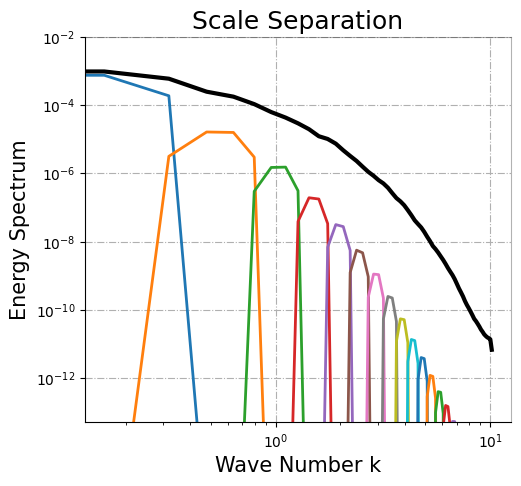

In [2]:
sample = np.load("data/fluid/Re_180_1.npy")
sample = sample[None, :2]
T = sample.shape[2]
H = sample.shape[-2]
W = sample.shape[-1]
wave_numbers, spec_target = spectrum1d(sample)
torch_sample = torch.from_numpy(sample).reshape(1, T*2, H, W)
limits = torch.fft.rfftfreq(min(H, W))
spectrums, separate_scales = [], []
for i in range(len(limits)-1):  
    separate_scale = FourierFilter(torch_sample, limits[i], limits[i+1]).reshape(1, 2, T, H, W).real
    spectrums.append(spectrum1d(separate_scale))

fig=plt.figure(figsize=(5.5, 5))
plt.plot(wave_numbers, spec_target,  linewidth = 3, color = "black", label = "Target")
for i in range(0, len(spectrums), 3):
    plt.plot(spectrums[i][0], spectrums[i][1], linewidth = 2, label = str(limits[i]))

plt.yscale("log")
plt.xscale("log")
plt.ylim(5e-14, 10e-3)
# plt.legend(fontsize=8, loc = 3)
plt.ylabel("Energy Spectrum", size = 15)
plt.xlabel("Wave Number k", size = 15)
plt.title("Scale Separation", size = 18)

plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(1)   

plt.grid(True, linestyle='-.')
# plt.show()
# plt.savefig("imgs/scale_separation.png", dpi = 200, bbox_inches = 'tight')

## 2. Discovering Istropy Breaking 

In [3]:
all_equiv_errors = []
# Average over five runs with different random seeds
for seed in range(5):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    freq_list = torch.fft.rfftfreq(128)
    in_channels = 1
    out_channels = 1
    kernel_size = 5
    hidden_dim = 16
    num_filter_basis = 1
    batch_size = 128
    learning_rate = 0.001
    decay_rate = 0.9
    num_epoch = 30
    train_indices = np.arange(0, 1800)
    valid_indices = np.arange(1800, 2000)

    data_direc = "data/fluid/Re_180_1.npy"
    train_set = DatasetFluid2D(direc = data_direc, sample_list = train_indices)
    valid_set = DatasetFluid2D(direc = data_direc, sample_list = valid_indices)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = False, num_workers = 2)   


    model = IsoSymDisNet2D(in_channels = in_channels,
                           out_channels = out_channels,
                           hidden_dim = hidden_dim, 
                           num_filter_basis = num_filter_basis,
                           group_order = 8,
                           kernel_size = kernel_size, 
                           freq_list = freq_list).to(device)

    best_model = train_model_batch(model, train_loader, valid_loader, num_epoch, learning_rate, decay_rate)
    
    learnt_relaxed_weights = torch.stack([best_model.model[i][0].relaxed_weights for i in range(len(best_model.model))]).cpu().data.numpy()
    # Normalize relaxed weights for each scale
    learnt_relaxed_weights = (learnt_relaxed_weights - learnt_relaxed_weights.min(1, keepdims = True))/learnt_relaxed_weights.max(1, keepdims = True) - learnt_relaxed_weights.min(1, keepdims = True)
    # Calculate the equivariance error based on the learnt relaxed weights
    # \sum_{g \in G} |w(e) - w(g)|
    equiv_error = np.mean(np.abs(learnt_relaxed_weights - learnt_relaxed_weights[:,:1]), axis = (-1,-2))
    all_equiv_errors.append(equiv_error)
    
all_equiv_errors = np.array(all_equiv_errors)
std_equiv_error = np.std(all_equiv_errors, axis = 0)
avg_equiv_error = np.mean(all_equiv_errors, axis = 0)

/global/homes/r/rwang2/.conda/envs/e3nn/lib/python3.9/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch 1 | T: 0.19 | Train MAE: 0.92425 | Valid MAE: 0.29877 | LR 0.000900
Epoch 11 | T: 0.16 | Train MAE: 0.00737 | Valid MAE: 0.00734 | LR 0.000314
Epoch 21 | T: 0.26 | Train MAE: 0.00699 | Valid MAE: 0.00699 | LR 0.000109
Epoch 1 | T: 0.33 | Train MAE: 0.02943 | Valid MAE: 0.00801 | LR 0.000900
Epoch 11 | T: 0.33 | Train MAE: 0.00539 | Valid MAE: 0.00536 | LR 0.000314
Epoch 21 | T: 0.16 | Train MAE: 0.00522 | Valid MAE: 0.00522 | LR 0.000109
Epoch 1 | T: 0.16 | Train MAE: 0.06950 | Valid MAE: 0.04162 | LR 0.000900
Epoch 11 | T: 0.16 | Train MAE: 0.00551 | Valid MAE: 0.00551 | LR 0.000314
Epoch 21 | T: 0.16 | Train MAE: 0.00538 | Valid MAE: 0.00539 | LR 0.000109
Epoch 1 | T: 0.16 | Train MAE: 0.25950 | Valid MAE: 0.05346 | LR 0.000900
Epoch 11 | T: 0.16 | Train MAE: 0.00553 | Valid MAE: 0.00555 | LR 0.000314
Epoch 21 | T: 0.16 | Train MAE: 0.00547 | Valid MAE: 0.00550 | LR 0.000109
Epoch 1 | T: 0.16 | Train MAE: 0.16086 | Valid MAE: 0.00676 | LR 0.000900
Epoch 11 | T: 0.16 | Train MAE

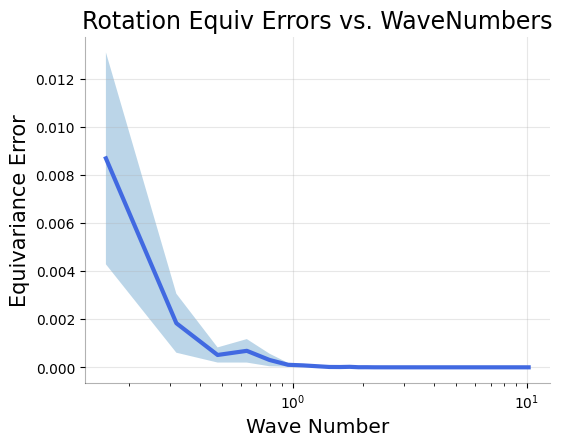

In [4]:
fig=plt.figure(figsize=(6, 4.5))
plt.plot(wave_numbers[1:], avg_equiv_error, color = "royalblue", linewidth = 3)
plt.fill_between(wave_numbers[1:], (avg_equiv_error-std_equiv_error), (avg_equiv_error+std_equiv_error), alpha=.3)
plt.ylabel("Equivariance Error", size = 15)
plt.xlabel("Wave Number", size = 14.5)
plt.title("Rotation Equiv Errors vs. WaveNumbers", size = 17)
plt.grid(axis='both', alpha=.3)
plt.xscale("log")

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
# plt.show()
plt.savefig("iso_breaking.png", dpi = 200, bbox_inches = 'tight')